# Testing Mitiq ZNE in OpenQAOA

## Creation of the graph + QUBO model

In [1]:
def create_graph(nodes,edges):
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)
    return graph

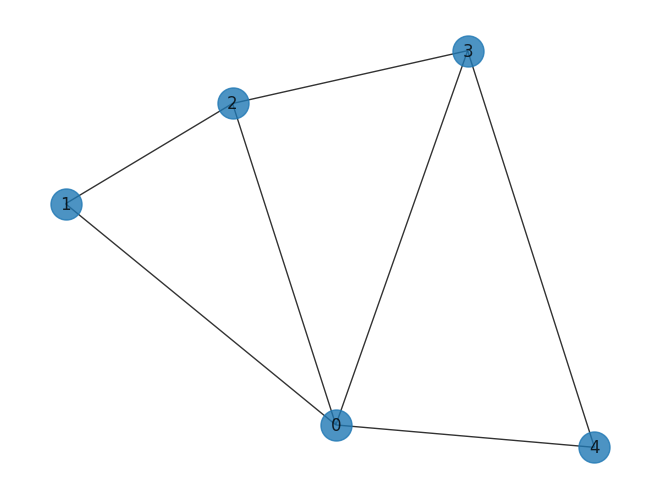

In [2]:
import networkx as nx
from openqaoa.problems import MaximumCut

G = create_graph(
[0, 1, 2, 3, 4],
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (2, 3), (3, 4)] 
)

#Inner OpenQAOA function for ploting graphs
#plot_graph(graph)

# Create a MaximumCut instance from the graph and get its QUBO and hamiltonian
maxcut_prob = MaximumCut(G)
maxcut_qubo = maxcut_prob.qubo
maxcut_hamiltonian = maxcut_qubo.hamiltonian

## Creation of the QAOA + Mitiq ZNE class

In [15]:
from openqaoa import QAOA  
q = QAOA()
q

In [16]:
from openqaoa.backends import create_device

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q.set_device(qiskit_device)




## Adding a noise model

In [17]:
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
device_backend = FakeVigo()
device = QasmSimulator.from_backend(device_backend)
noise_model = NoiseModel.from_backend(device)


q.set_backend_properties(n_shots=13000, seed_simulator=1, noise_model = noise_model)


C:\Users\Adriano\AppData\Local\Temp\ipykernel_11448\3672717589.py:1: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeVigo


In [18]:
from qiskit_aer.noise import (NoiseModel, depolarizing_error)

one_qubit_gates = ['id','x','sx','rz']
two_qubits_gates = ['cx']

#create depol. noise
def add_depolarizing_error(noise_model,prob):
    noise_model = add_one_qubit_depolarizing_error(noise_model,prob)
    noise_model = add_two_qubits_depolarizing_error(noise_model,prob)
    return noise_model

#create 1 qubit depol. noise
def add_one_qubit_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 1)
    noise_model.add_all_qubit_quantum_error(error,one_qubit_gates)
    return noise_model

#create 2 qubits depol.noise
def add_two_qubits_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 2)
    noise_model.add_all_qubit_quantum_error(error, two_qubits_gates)
    return noise_model

noise_model = add_depolarizing_error(NoiseModel(),1)
q.set_backend_properties(n_shots=10000, seed_simulator=1, noise_model = noise_model)

## Requesting Mitiq ZNE mitigation and compiling

In [19]:
q.set_error_mitigation_properties(
    error_mitigation_technique='mitiq_zne',n_batches=4,calibration_data_location="caldata.json"
)
q.compile(maxcut_qubo)

In [20]:
q.backend

## Optimization

In [ ]:
q.optimize()

## Getting the solution

result:  ['01011']
states kept: 32


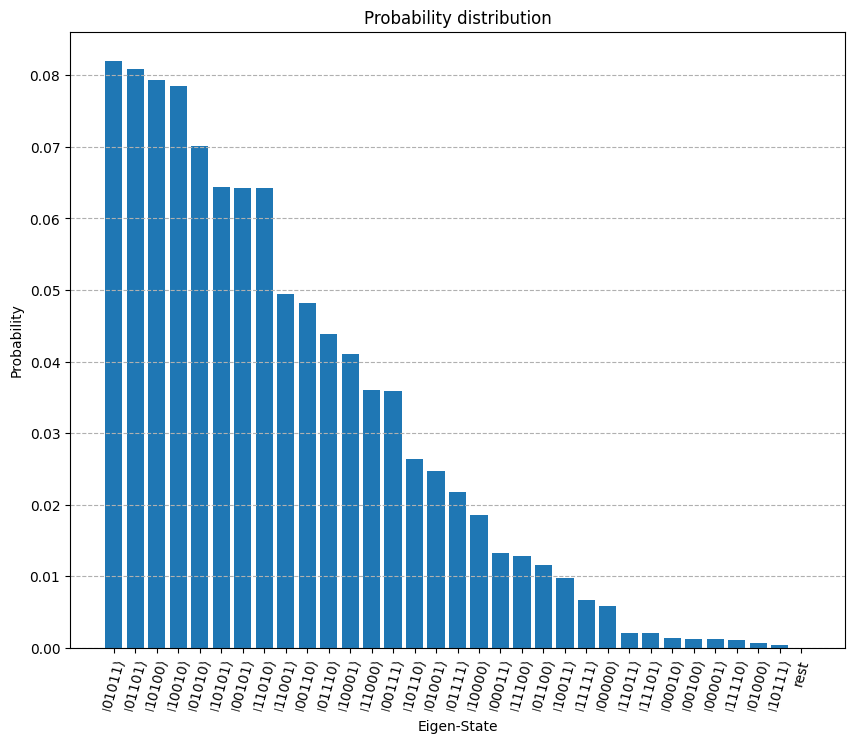

In [10]:
result = q.result
print('result: ',result.most_probable_states['solutions_bitstrings'])
result.plot_probabilities()

## Comparing with standard QAOA, without noise

In [11]:
q1 = QAOA()
q1.set_device(qiskit_device)


q1.compile(maxcut_qubo)

In [12]:
q1.optimize()

result:  ['01011']
states kept: 32


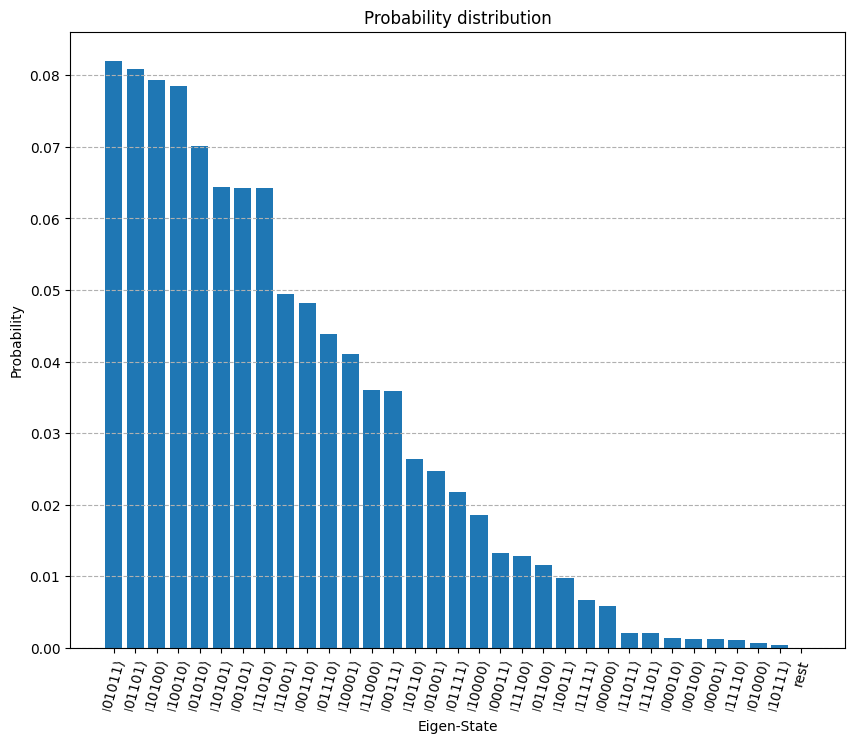

In [13]:
result = q.result
print('result: ',result.most_probable_states['solutions_bitstrings'])
result.plot_probabilities()